In [19]:
import numpy as np
import scipy as sp
import astropy as ap

import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.ndimage 
import PIL

In [20]:
h_0 = 67.66 #Hubble Const from Planck km s-1 Mpc-1
c = 299792458 #Speed of Light m s-1
h = 0.7 #Reduced Hubble Const
om_k = 0 #Omega for Curvature
om_m = 0.3 #Omega Matter
om_lam = 0.7 #Omega Dark Energy
om_r = 0.0 #Omega Radiation
n = 1 
sig_8 = 0.9
G = 6.67e-11 # m3 kg-1 s-2
d_h0 = c*10**(-3)/h_0 # Hubble dist at current time 

# Need to find how the error in comoving distance scales with errors in redshift of 
$$ \sigma_8 = 0.01 (1+z) $$

In [27]:
z = np.arange(0,10,0.01)
def E(z):
    return(om_m*(1+z)**3 + om_k*(1+z)**2 + om_lam)

D_C = [d_h0*quad(E,0,zed)[0] for zed in z]


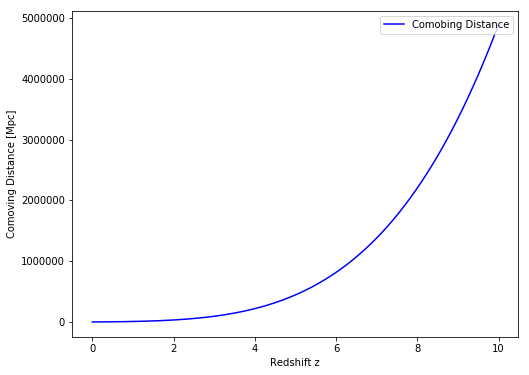

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z,D_C,'b-',label='Comobing Distance')
ax.set_xlabel('Redshift z')
ax.set_ylabel('Comoving Distance [Mpc]')
ax.legend(loc = 'upper right')


# Need to estimate SZ signal from single galaxy pair, then scale appropriately

### Need to find method of rotating array for stacking purposes

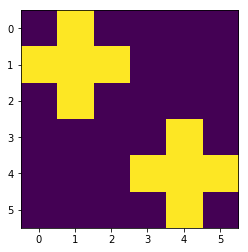

Rotation by 45 degrees


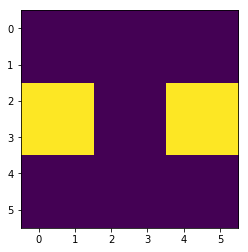

Rotation by 55 degrees
[[0 0 0 0 1 0]
 [0 0 0 1 1 1]
 [0 1 0 0 1 0]
 [1 1 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]]


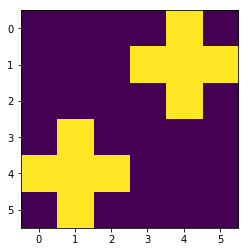

In [6]:
#Need to learn how to rotate array

matr_1= [[0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0]]

matr_2= [[0, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0]]

plt.imshow(matr_1)
plt.show()
print("Rotation by 45 degrees")
#print(sp.ndimage.rotate(matr_1, 45, reshape=False))
plt.imshow(sp.ndimage.rotate(matr_1,45,reshape=False))
plt.show()
print("Rotation by 55 degrees")
print(sp.ndimage.rotate(matr_2, 90, reshape=False))
plt.imshow(sp.ndimage.rotate(matr_1,90,reshape=False))


Original Matrix
Original Dimension = (6, 6)


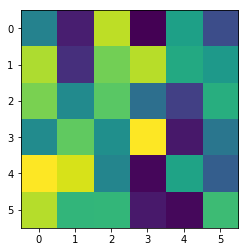

Rotated Matrix
Rotated Dimension = (8, 8)


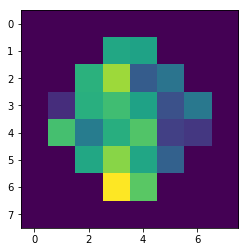

In [7]:
rand_matr = np.random.rand(6,6)
print("Original Matrix")
print("Original Dimension = " + str(np.shape(rand_matr)))
#print(rand_matr)
plt.imshow(rand_matr)
plt.show()
print("Rotated Matrix")
rot_matr = sp.ndimage.rotate(rand_matr, 45, reshape=True)
print("Rotated Dimension = "+ str(np.shape(rot_matr)))
#print(rot_matr)
plt.imshow(rot_matr)
plt.show()

Can use the above method to rotate matrix, but there is some loss of information, so must ensure this doesn't affect the calculation too much


# Need to Consider Galaxy Selection Criteria
## LRG Criteria from Literature
1709.05024

LRG Paper Selects $M_\star>10^{11.3} M_\odot$ and reject satellite LRGs by discounting them if there is a more massive LRG within $1 h^-1 $Mpc and within radial velocity dist $|c \Delta z | < 1000 $km/s

LRG Pairs are chosen by finding all neighboring pairs of LRG's within $6-10 h^-1$ Mpc tangential distance, and within a proper radial distance of $\pm 6 h^-1$ Mpc

262,864 LRG Pairs out to $z\approx 0.4$

## Galaxy Selection from Literature
1709.10378v2

Using CMASS Galaxy Catalogue from SDSS DR12, galaxies were selected so that they are separated by up to $>20 h^-1$ Mpc

Projected Separation of $6-14 h^-1$ Mpc and line of sight separation of $>5 h^-1$ Mpc

~1,000,000 Galaxy Pairs found with mean separation $10 h^-1$ Mpc, which puts it well beyond host DM halo



Might want to consider developing a class to make processing easier


Looking into things, it appears that they use the target locations in from the Catalogues, and the stacking method to characterise the filament structure from the y-map. Need to normalise the projected length, to make the stacking effective, and null shear effects away. Unsure if we can use photo-z instead of spectral-z for this, and how the noise statistics change for either. 